In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import zindex.zindex as zz

/Users/pete/miniconda3/envs/cenv3/lib/python3.6/site-packages/numba/errors.py:102: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [3]:
import random
import zindex.zindex as zz

width = 10
height = 10
test_bounds = [0,0,width,height]

def get_random_bounds():
    min_pos = [random.random(), random.random()]
    a = 1 - min_pos[0]
    b = 1 - min_pos[1]
    max_pos = [min_pos[0] + a * random.random(), min_pos[1] + b * random.random()]
    #print(min_pos, max_pos)
    query_bounds = width * np.array(min_pos + max_pos)
    return query_bounds
    
def run_query_z_index(new_points_list):
    #print(query_bounds)
    query_bounds = get_random_bounds()
    
    return zz.get_points(new_points_list, query_bounds, test_bounds, test_bounds)

def run_query_filter(new_points_list):
    query_bounds = get_random_bounds()
    
    x = new_points_list
    
    x = x[x[:,0] > query_bounds[0]]
    x = x[x[:,1] > query_bounds[1]]
    x = x[x[:,0] < query_bounds[2]]
    x = x[x[:,1] < query_bounds[3]]
    
    return x

In [4]:
import numpy as np

new_points = width * np.random.random((2048000,2))
zoom = 32


    
%time spoints, sorted_interleaved = zz.sort_points(new_points, test_bounds, zoom=zoom)
%time np.sort(new_points)
print(spoints[:10])

CPU times: user 713 ms, sys: 73.6 ms, total: 787 ms
Wall time: 792 ms
CPU times: user 46.9 ms, sys: 3.11 ms, total: 50 ms
Wall time: 48.7 ms
[[0.00189154 0.00344539]
 [0.00220576 0.0094589 ]
 [0.01005317 0.00016553]
 [0.01315493 0.00025317]
 [0.0001053  0.01280506]
 [0.00630142 0.01190121]
 [0.00744531 0.01742257]
 [0.01803569 0.01850134]
 [0.02593517 0.00146585]
 [0.02627944 0.00380747]]


In [5]:
"""
unordered_points = np.array([
    [6,4],[7,1],[2,2],[3,1],[3,4],[0,4],[1,6],[4,2]
])

zoom = 16
ordered_points, sorted_interleaved = sort_points(unordered_points,
                                                np.array([0,0,8,8]),
                                                 zoom)
"""

'\nunordered_points = np.array([\n    [6,4],[7,1],[2,2],[3,1],[3,4],[0,4],[1,6],[4,2]\n])\n\nzoom = 16\nordered_points, sorted_interleaved = sort_points(unordered_points,\n                                                np.array([0,0,8,8]),\n                                                 zoom)\n'

In [6]:
width = 1
height = 1
test_bounds = np.array([0,0,width,height])
zoom=32

import math

def old_get_random_bounds(size_fraction=0.1):
    assert(size_fraction < 1)
    
    x_width = size_fraction + (random.random() * min(1 - size_fraction, 1 / size_fraction))
    y_width = size_fraction / x_width
    
    x_pos = random.random() * (1 - x_width)
    y_pos = random.random() * (1 - y_width)
    
    #print('x_width:', x_width, "y_width:", y_width, x_width * y_width)
    return np.array([x_pos, y_pos, x_pos + x_width, y_pos + y_width])
    
def get_random_bounds(size_fraction=0.1):
    assert(size_fraction < 1)
    
    width_fraction = math.sqrt(size_fraction)
    
    x_pos= random.random() * (1 - width_fraction)
    y_pos = random.random() * (1 - width_fraction)
    
    
    x_width = random.random() * width_fraction
    y_width = random.random() * width_fraction
    
    #print('x_width:', x_width, "y_width:", y_width, x_width * y_width)
    return np.array([x_pos, y_pos, x_pos + x_width, y_pos + y_width])

get_random_bounds(.0001)

array([0.28161568, 0.86132444, 0.28761414, 0.86186701])

In [7]:

    
def run_query_z_index(sorted_interleaved, size_fraction=0.1):
    #print(query_bounds)
    query_bounds = get_random_bounds(size_fraction)

    t1 = time.time()
    points = zz.get_points(sorted_interleaved, query_bounds, test_bounds, zoom)
    t2 = time.time()
    #print("t2 - t1: {:.4f}".format(1000 * (t2 - t1)), query_bounds, len(points))
    
    return points

def run_query_filter(new_points_list, size_fraction=0.1):
    query_bounds = get_random_bounds(size_fraction)
    
    x = new_points_list
    
    x = x[x[:,0] > query_bounds[0]]
    x = x[x[:,1] > query_bounds[1]]
    x = x[x[:,0] < query_bounds[2]]
    x = x[x[:,1] < query_bounds[3]]
    
    return x

In [98]:
import numpy as np
import time
import timeit
times = []

"""for i in ([1000, 2000, 4000, 8000, 16000, 32000, 64000, 128000, 
           256000, 512000, 1024000, 2048000, 4096000,
          8192000, 16384000, 32768000, 65536000, 131072000]):"""
for i in range(14,15):
    num_points = 1000 * 2**i #100000000
    new_points = width * np.random.random((num_points,2))
    ts1 = time.time()
    #new_points_list = zz.zindex_sort(new_points, test_bounds)
    ordered_points, sorted_interleaved = sort_points(new_points,
                                                np.array([0,0,width,width]),
                                                 zoom)
    ts2 = time.time()
    t1 = ts2 - ts1

    new_points_copy = np.copy(new_points)
    ts1 = time.time()
    np.sort(new_points_copy)
    ts2 = time.time()
    t0 = ts2 - ts1
    
    num1 = 100
    num2 = 10
    query_times = {}
    
    t2_0001 = timeit.timeit(lambda: run_query_z_index(sorted_interleaved, 0.0001), number=num1)
    t3_0001 = timeit.timeit(lambda: run_query_filter(ordered_points, 0.0001), number=num2)

    t2_01 = timeit.timeit(lambda: run_query_z_index(sorted_interleaved, 0.01), number=num1)
    t3_01 = timeit.timeit(lambda: run_query_filter(ordered_points, 0.01), number=num2)
    
    t2_1 = timeit.timeit(lambda: run_query_z_index(sorted_interleaved, 0.1), number=num1)
    t3_1 = timeit.timeit(lambda: run_query_filter(ordered_points, 0.1), number=num2)
    '''
        query_times["{}% brute".format(size_fraction)] = t3
        query_times["{}% z-index".format(size_fraction)] = t1
    
    times += [{
        "num_points": num_points,
        "numpy sort (ms)": 1000 * t0,
        "z-index sort (ms)": 1000 * t1,
        "query times (ms)": query_times
    }]
    '''
    
    times += [[num_points, 1000 * t0, 1000 * t1, 
               1000 * t2_0001 / num1, 1000 * t2_01 / num1, 1000 * t2_1 / num1,
                1000 * t3_0001 / num2, 1000 * t3_01 / num2, 1000 * t3_1 / num2,
              ]]
    print(["{:.4f}".format(t) for t in times[-1]])
    
#print("times:", times) 

['16384000.0000', '525.2120', '8585.0854', '0.7647', '8.3281', '27.4932', '867.0302', '710.0973', '690.1324']


In [221]:
%%time

bounds = np.array([0,0,width,width])

res = 10


import itertools as it
a = 1
zoom = 32
tile_width = (bounds[2] - bounds[0]) / 2 ** zoom
x = np.linspace(0,width-tile_width, 100)

for i,j in it.product(x,x):
    point = (np.array([(i - bounds[0]) // tile_width, (j - bounds[0]) // tile_width])
             .astype(np.uint64)) #.astype(np.uint64)
    #print("dtype:", point.dtype)
    #print("point:", point)
    interleaved = zz.interleave1(point)
    #print("interleave1", interleaved)
    li = np.searchsorted(sorted_interleaved, np.array([interleaved]).astype(np.uint64))
    #print("li:", li, "interleaved:", interleaved)
    #if li < len(ordered_points):
    #    print("point:", i,j, "found:", ordered_points[li])
    #print("interleaved:", interleaved)
    # a += 1
    #nn = zz.nearest_neighbor(point, sorted_interleaved, bounds, zoom)

CPU times: user 95.8 ms, sys: 3.15 ms, total: 99 ms
Wall time: 97.3 ms


In [266]:
%%time

bounds = np.array([0,0,width,width])

a = 1
zoom = 32
tile_width = (bounds[2] - bounds[0]) / 2 ** zoom

xmin = 0
xmax = width - tile_width
ymin = 0
ymax = width - tile_width

X, Y = np.mgrid[xmin:xmax:256j, ymin:ymax:256j]
positions = np.vstack([X.ravel(), Y.ravel()]).T
int_points = ((positions - bounds[0]) // tile_width).astype(np.uint64)
interleaved = zz.interleave(int_points[:,0], int_points[:,1])

indeces = np.searchsorted(sorted_interleaved, interleaved)
points = ordered_points[indeces[indeces < len(ordered_points)]]
fpositions = positions[indeces < len(ordered_points)]

CPU times: user 133 ms, sys: 2.11 ms, total: 135 ms
Wall time: 135 ms


In [269]:
len(ordered_points)

16384000

In [268]:
max(((points - fpositions) ** 2).sum(axis=1))

0.015560590789259572

In [200]:
import bisect
import numpy as np

In [210]:
%%timeit

li = np.searchsorted(sorted_interleaved, np.array(2459565876494606882).astype(np.uint64))

2.66 µs ± 68.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [211]:
print(li)

16384000


In [208]:
%%timeit

li = bisect.bisect_left(sorted_interleaved, 2459565876494606882)

46.7 µs ± 333 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [209]:
print(li)

16384000


In [205]:
sorted_interleaved.dtype

dtype('uint64')

In [193]:
len(sorted_interleaved)

16384000

In [145]:



for x in range(1000):
    point = [np.random.random() * width, np.random.random() * width]
    #print(point)

    nn = zz.nearest_neighbor(point, sorted_interleaved, bounds)

    for i in range(0, len(nn), 2):
        #print("nn:", nn)
        left,right = nn[i:i+2]

        #print("left, right", left, right)

/Users/pete/miniconda3/envs/cenv3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,lat,lon,poi_town,admin_area
0,9999765,15.23850,-23.21325,1025.615690,Africa
1,9999766,15.30073,-23.19242,4514.848251,Africa
2,9999767,15.12082,-23.18732,2546.846200,Africa
3,9999768,15.27154,-23.23572,3484.165707,Africa
4,9999769,15.17577,-23.15718,1300.567389,Africa


/Users/pete/miniconda3/envs/cenv3/lib/python3.6/site-packages/numba/errors.py:102: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


tile_width: 4.190951585769653e-08


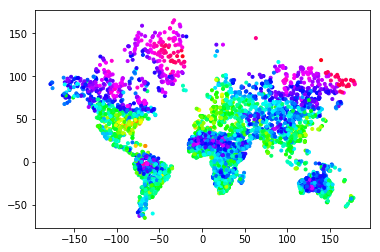

CPU times: user 51.8 s, sys: 1.21 s, total: 53 s
Wall time: 58 s


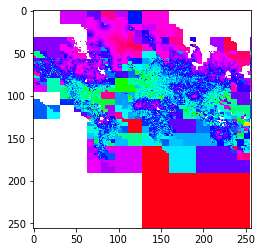

CPU times: user 362 ms, sys: 174 ms, total: 536 ms
Wall time: 417 ms


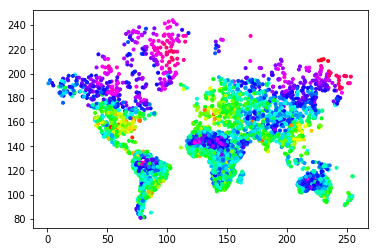

In [586]:
plt.scatter(((rand[:,0] + 180) / 360) * width, ((rand[:,1] + 180) / 360) * width, c=x, marker='.', cmap='hsv')

tile_width: 8.381903171539307e-08 360


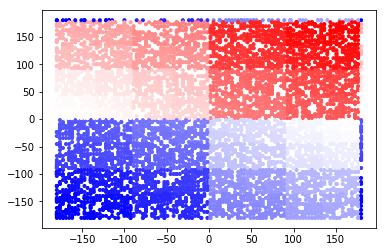

## Detritus

In [4]:
%%time
import functools as ft
import numpy as np

print(zz.tile_children(0,0,1,1))

test_bounds = [0,0,2,2]
new_points = [ [ 0.64297498,  0.53004252], [ 0.64344366,  0.52946568]]
new_points_list = sorted(new_points, key=ft.cmp_to_key(lambda a,b: zz.zindex_compare(a,b, *test_bounds)))

assert(zz.zindex_compare(np.array([2,2]), np.array([2,2]), 0,0,8,8) == 0)
assert(zz.zindex_compare(np.array([0,4]), np.array([3,4]), 0,0,8,8) == -1)
assert(zz.zindex_compare([6,4], [3,1], 0,0,8,8) == 1)
assert(zz.zindex_compare([3,1], [2,2], 0,0,8,8) == -1)
assert(zz.zindex_compare([2,2], [3,1], 0,0,8,8) == 1)
assert(zz.zindex_compare([7,1], [2,2], 0,0,8,8) == 1)
assert(zz.zindex_compare([2,2], [7,1], 0,0,8,8) == -1)

[0.  0.  0.5 0.5 0.  0.5 0.5 1.  0.5 0.  1.  0.5 0.5 0.5 1.  1. ]
CPU times: user 1.46 s, sys: 21.2 ms, total: 1.48 s
Wall time: 1.48 s


In [60]:
unordered_points = np.array([
    [6,4],[7,1],[2,2],[3,1],[3,4],[0,4],[1,6],[4,2]
])

np.reshape(unordered_points, (-1,))

/Users/pete/miniconda3/envs/cenv3/lib/python3.6/site-packages/numba/decorators.py:232: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


array([6, 4, 7, 1, 2, 2, 3, 1, 3, 4, 0, 4, 1, 6, 4, 2])

In [63]:
%%time 
import functools as ft

points_list = np.array(sorted(np.copy(unordered_points), 
                              key=ft.cmp_to_key(lambda a,b: zz.zindex_compare(a[0],a[1], b[0], b[1], *[0,0,8,8]))))
# correct order:
"""[[3 1]
 [2 2]
 [7 1]
 [4 2]
 [0 4]
 [3 4]
 [1 6]
 [6 4]]"""
print(points_list)

[[3 1]
 [2 2]
 [7 1]
 [4 2]
 [0 4]
 [3 4]
 [1 6]
 [6 4]]
CPU times: user 358 ms, sys: 5.53 ms, total: 364 ms
Wall time: 370 ms


In [72]:
%%time

points_list1 = zz.zindex_sort(np.copy(unordered_points), [0,0,8,8])
print(points_list1)

[[3 1]
 [2 2]
 [7 1]
 [4 2]
 [0 4]
 [3 4]
 [1 6]
 [6 4]]
CPU times: user 513 µs, sys: 198 µs, total: 711 µs
Wall time: 573 µs


In [73]:
unordered_points = np.random.random((4000,2))



In [56]:
%%time 

expanded_points = np.copy(unordered_points).reshape((-1,))
points_list1 = zz.quicksort_zindex(expanded_points, 
                                   0, len(unordered_points), 
                                   *[0,0,8,8]).reshape((-1,2))

CPU times: user 40.5 ms, sys: 828 µs, total: 41.3 ms
Wall time: 41.6 ms


In [57]:
%%time 

points_list = np.array(sorted(np.copy(unordered_points), 
                              key=ft.cmp_to_key(lambda a,b: zz.zindex_compare(a,b, *[0,0,8,8]))))



CPU times: user 51.6 ms, sys: 2.52 ms, total: 54.1 ms
Wall time: 53.2 ms


In [58]:
a = [[1,2],[3,4],[5,6],[7,8]]

a[3] = a[1]
a[1] = [9,10]
a

[[1, 2], [9, 10], [5, 6], [3, 4]]

In [66]:

"""
big_tile=[0,0,8,8]
print(points_list)
print(zz.lower_bound(np.array(points_list), np.array([1,6]), 0,0,8,8))

print(zz.upper_bound(np.array(points_list), np.array([1,6]), 0,0,8,8))
print(zz.all_points(points_list, [0.0, 0.0, 4.0, 4.0], big_tile))

print(zz.get_points(points_list, [0,0,4,4], [0,0,8.,8.], [0,0,16,16]))
print(zz.get_points(points_list, [0,0,5,5], [0,0,8.,8.], [0,0,16,16]))
print(zz.get_points(points_list, [0.,0.,8.,1.5], [0.,0.,8.,8.], [0.,0.,16.,16.]))
new_points = np.array([ [ 0.64297498,  0.53004252], [ 0.64344366,  0.52946568]])

new_points_list1 = zz.quicksort_zindex(new_points, 0, len(new_points)-1, *test_bounds)
new_points_list2 = sorted(new_points, key=ft.cmp_to_key(lambda a,b: zz.zindex_compare(a,b, *test_bounds)))
"""
#print(new_points_list)

'\nbig_tile=[0,0,8,8]\nprint(points_list)\nprint(zz.lower_bound(np.array(points_list), np.array([1,6]), 0,0,8,8))\n\nprint(zz.upper_bound(np.array(points_list), np.array([1,6]), 0,0,8,8))\nprint(zz.all_points(points_list, [0.0, 0.0, 4.0, 4.0], big_tile))\n\nprint(zz.get_points(points_list, [0,0,4,4], [0,0,8.,8.], [0,0,16,16]))\nprint(zz.get_points(points_list, [0,0,5,5], [0,0,8.,8.], [0,0,16,16]))\nprint(zz.get_points(points_list, [0.,0.,8.,1.5], [0.,0.,8.,8.], [0.,0.,16.,16.]))\nnew_points = np.array([ [ 0.64297498,  0.53004252], [ 0.64344366,  0.52946568]])\n\nnew_points_list1 = zz.quicksort_zindex(new_points, 0, len(new_points)-1, *test_bounds)\nnew_points_list2 = sorted(new_points, key=ft.cmp_to_key(lambda a,b: zz.zindex_compare(a,b, *test_bounds)))\n'

In [79]:
import random
import zindex.zindex as zi

width = 100
test_bounds = [0,0,width,width]

def get_random_bounds():
    min_pos = [random.random(), random.random()]
    a = 1 - min_pos[0]
    b = 1 - min_pos[1]
    max_pos = [min_pos[0] + a * random.random(), min_pos[1] + b * random.random()]
    #print(min_pos, max_pos)
    query_bounds = min_pos + max_pos
    return query_bounds
    
def run_query_z_index(new_points_list):
    #print(query_bounds)
    query_bounds = get_random_bounds()
    
    return zi.get_points(new_points_list, query_bounds, test_bounds, test_bounds)

def run_query_filter(new_points_list):
    query_bounds = get_random_bounds()
    
    x = new_points_list
    
    x = x[x[:,0] > query_bounds[0]]
    x = x[x[:,1] > query_bounds[1]]
    x = x[x[:,0] < query_bounds[2]]
    x = x[x[:,1] < query_bounds[1]]
    
    return x

In [88]:
import time
import timeit
times = []

for i in ([1000, 2000, 4000, 8000, 16000, 32000, 64000, 128000, 
           256000, 512000, 1024000, 2048000, 4096000,
          8192000, 16384000, 32768000, 65536000, 131072000]):
#for i in ([2048000, 4096000, 8192000, 16384000]):
    new_points = 100 * np.random.random((i,2))
    ts1 = time.time()
    new_points_list = zz.zindex_sort(new_points, test_bounds)
    ts2 = time.time()
    
    t1 = ts2 - ts1
    num = 20
    t2 = timeit.timeit(lambda: run_query_z_index(new_points_list), number=num)
    t3 = timeit.timeit(lambda: run_query_filter(new_points_list), number=num)
    times += [[i, 1000 * t1, 1000 * t2 / num, 1000 * t3 / num]]
    print(times[-1])
    
print("times:", times) 

[1000, 12.845754623413086, 0.050030346028506756, 0.11947890743613243]
[2000, 13.593673706054688, 0.054146908223629, 0.09248870192095637]
[4000, 32.32598304748535, 0.31762439757585526, 0.2326757530681789]
[8000, 62.39724159240723, 0.057877355720847845, 0.29814474983140826]
[16000, 128.01408767700195, 0.18645740346983075, 0.7739907945506275]
[32000, 286.3619327545166, 0.37012904649600387, 1.3291987008415163]
[64000, 634.7901821136475, 0.3314267029054463, 3.286579600535333]
[128000, 1337.968111038208, 0.35391999408602715, 5.5846595438197255]
[256000, 2874.2218017578125, 0.7159242988564074, 11.73308469587937]
[512000, 5767.416954040527, 0.6679147481918335, 22.836200310848653]
[1024000, 12900.49695968628, 1.5442186500877142, 49.07309775007889]
[2048000, 28464.2550945282, 3.0788553529419005, 103.21310785366222]


KeyboardInterrupt: 

In [ ]:
# JIT compiled get_points function and quicksort function
[[1000, 8.343696594238281, 5.857501155696809],
[2000, 14.657974243164062, 8.73991585103795],
[4000, 32.17267990112305, 9.934303304180503],
[8000, 66.30706787109375, 19.047390355262905],
[16000, 150.0110626220703, 22.90619524428621],
[32000, 338.67597579956055, 29.36189044266939],
[64000, 699.23996925354, 46.52934119803831],
[128000, 1630.383014678955, 81.52290630387142],
[256000, 3382.7571868896484, 121.25531400088221],
[512000, 7451.72905921936, 165.87364844745025],
[1024000, 16158.413648605347, 201.22555199777707],
[2048000, 34105.74817657471, 451.70394025044516],
[4096000, 71596.06003761292, 501.6868827515282]]

In [159]:
#Naive, JIT compiled

times =  np.array([[1000, 9.168863296508789, 50.41221599676646],
[2000, 16.98470115661621, 93.40575349633582],
[4000, 36.752939224243164, 134.90044319769368],
[8000, 90.03210067749023, 215.87846255279146],
[16000, 181.4291477203369, 318.6693516501691],
[32000, 403.6710262298584, 566.6372809500899],
[64000, 885.6968879699707, 947.4282511975616],
[128000, 1955.841064453125, 1438.8111696520355],
[256000, 4423.8152503967285, 1898.9170490473043],
[512000, 9313.93575668335, 2943.4117220458575],
[1024000, 19957.006216049194, 3433.2461752987],
[2048000, 42536.39817237854, 5050.250917550875],
[4096000, 91611.70196533203, 7668.613841303159],               
])

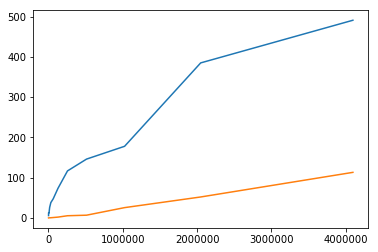

In [83]:
import matplotlib.pyplot as plt
times = np.array(times)
plt.plot(times[:,0], times[:,2])
plt.plot(times[:,0], times[:,3])

In [82]:
rect=np.frombuffer(base64.decodestring(b'JHN5J0Z44j8PYCKBtAHvP7FAiVgJaO8/MR2NwbjM7z8='), dtype=np.float64)
tile=np.frombuffer(base64.decodestring(b'qP///3Mx6z8wHY3BuMzvP6r///9zMes/Mh2NwbjM7z8='), dtype=np.float64)
 
zz.tile_children(*tile).reshape((4,-1))[0]

/Users/peter/miniconda3/envs/cenv3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: decodestring() is a deprecated alias since Python 3.1, use decodebytes()
  """Entry point for launching an IPython kernel.
/Users/peter/miniconda3/envs/cenv3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: decodestring() is a deprecated alias since Python 3.1, use decodebytes()
  


array([0.84978676, 0.99374044, 0.84978676, 0.99374044])

In [94]:
for c in tile:
    print('{0:.16f}'.format(c))  
print('--------------')
for child in zz.tile_children(*tile).reshape((4,-1)):
    for c in child:
        print('{0:.16f}'.format(c))
    #print("child", child, rect)
    print(zz.all_in(child, rect))

0.8497867584228418
0.9937404423043628
0.8497867584228420
0.9937404423043630
--------------
0.8497867584228418
0.9937404423043628
0.8497867584228419
0.9937404423043629
True
0.8497867584228418
0.9937404423043629
0.8497867584228419
0.9937404423043630
True
0.8497867584228419
0.9937404423043628
0.8497867584228420
0.9937404423043629
True
0.8497867584228419
0.9937404423043629
0.8497867584228420
0.9937404423043630
True


In [90]:
zz.all_in(tile, rect)

ret1: False
ret2: False


False

In [ ]:
times1 = np.array([
    [1000, 159, 118],
    [2000, 374, 217],
    [4000, 810, 281],
    [8000, 1740, 462],
    [16000, 3880, 1000],
    [32000, 8810, 1350],
    [64000, 19800, 1470],
    [132000, 45000, 2830]
])

In [25]:
import random

%timeit random.randint(1,1000)

1.45 µs ± 13.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
